# Optimizing Diffuse Lighting

This tutorial describes how to optimize a single light probe given ground truth images while only modeling diffuse lighting effects.

We will describe how to use Kaolin implementation of Spherical Harmonics and Spherical Gaussians to represent light probes, render with them and optimize their parameters for a given scene.

For more details on the logic and usage of the approaches, we suggest to read the [MJP Blog post series on Spherical Gaussians](https://therealmjp.github.io/posts/new-blog-series-lightmap-baking-and-spherical-gaussians/)

In [ ]:
!pip install matplotlib
import kaolin as kal
import torch
import math
from matplotlib import pyplot as plt

def disp_imgs(imgs, title=None):
    """scatter images plotting"""
    nb_scenes, nb_views, _, _, _ = imgs.shape
    f, axes = plt.subplots(nb_scenes, nb_views, figsize=(1.95 * nb_views, 2. * nb_scenes))
    f.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(nb_views):
        for j in range(nb_scenes):
            axes[j, i].imshow(imgs[j, i].cpu().detach())
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])

## Loading 3D model

Here we are loading a simple sphere mesh with materials, which are preprocessed for rendering.


In [2]:
obj = kal.io.obj.import_mesh('../samples/colored_sphere.obj', with_materials=True, with_normals=True)

vertices = obj.vertices.cuda().unsqueeze(0)
# Normalize vertices in [-0.5, 0.5] range
vertices_max = vertices.max(dim=1, keepdim=True)[0]
vertices_min = vertices.min(dim=1, keepdim=True)[0]
vertices = ((vertices - vertices_min) / (vertices_max - vertices_min)) - 0.5

faces = obj.faces.cuda()
num_faces = faces.shape[0]
num_vertices = vertices.shape[1]
face_vertices = kal.ops.mesh.index_vertices_by_faces(vertices, faces)
# Face normals w.r.t to the world coordinate system
face_normals_idx = obj.face_normals.cuda()
normals = obj.vertex_normals.cuda().unsqueeze(0)
face_world_normals = kal.ops.mesh.index_vertices_by_faces(normals, face_normals_idx)

face_uvs_idx = obj.face_uvs_idx.cuda()
uvs = obj.uvs.cuda().unsqueeze(0)
face_uvs = kal.ops.mesh.index_vertices_by_faces(uvs, face_uvs_idx)
# Take diffuse texture map component from materials
texture = obj.materials[0]['map_Kd'].cuda().float().permute(2, 0, 1).unsqueeze(0) / 255.

## Camera

We instantiate a camera object and transform vertices into the camera coordinate frame to support rasterization.

In [3]:
cam_pos = torch.tensor([
    [0., 0., 1.],
    [0., -0.3, 0.9],
    [0., -0.5, 0.7],
    [0., -0.999, 0.111],
    [0., 0.999, 0.111],
    [0.5, 0., 0.5]
], device='cuda')
nb_views = cam_pos.shape[0]
cam_pos = cam_pos / cam_pos.norm(dim=-1, keepdim=True)
cam = kal.render.camera.Camera.from_args(
    eye=cam_pos,
    at=torch.tensor([[0., 0., 0.]], device='cuda').repeat(nb_views, 1),
    up=torch.tensor([[0., 1., 0.]], device='cuda').repeat(nb_views, 1),
    fov=70. * 2. * math.pi / 360,
    width=256, height=256, device='cuda'
)
vertices_camera = cam.extrinsics.transform(vertices)
vertices_ndc = cam.intrinsics.transform(vertices_camera)
face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(vertices_camera, faces)
face_vertices_image = kal.ops.mesh.index_vertices_by_faces(vertices_ndc[..., :2], faces)
face_vertices_z = face_vertices_camera[..., -1]

## Rasterize albedo and world normals

The first step toward rendering with lighting is to render the albedo (color) and normals in world coordinate system, as follows:

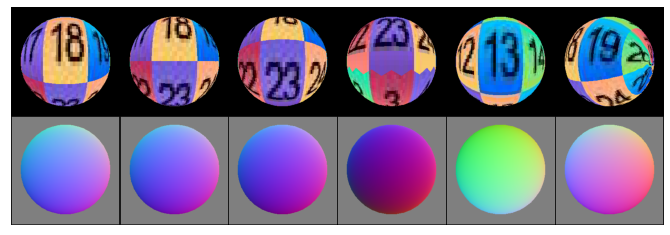

In [4]:
imsize = 256
im_features, face_idx = kal.render.mesh.rasterize(
    imsize, imsize, face_vertices_camera[..., -1], face_vertices_image,
    [face_uvs.repeat(nb_views, 1, 1, 1), face_world_normals.repeat(nb_views, 1, 1, 1)]
)
hard_mask = face_idx != -1
hard_mask = hard_mask
uv_map = im_features[0]
im_world_normal = im_features[1]
albedo = kal.render.mesh.texture_mapping(uv_map, texture.repeat(nb_views, 1, 1, 1))
albedo = torch.clamp(albedo * hard_mask.unsqueeze(-1), min=0., max=1.)
disp_imgs(torch.stack([albedo, ((im_world_normal + 1.) / 2.)], dim=0))

## Render synthetic ground truth

For the purpose of this demonstration, let us create synthetic ground truth renders we can use 
to drive optimization of the lighting parameters. In this case, we model a naive sun as a point at infinite distance with maximum intensity 1 and fixed light direction. Real photographs or renderings of a complex scene would
be used in a realistic scenario.

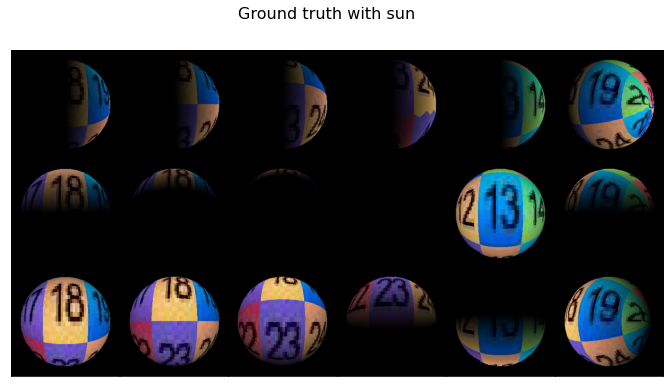

In [5]:
gt_azimuth = torch.tensor([0., math.pi / 2., 0.], device='cuda')
gt_elevation = torch.tensor([0., 0., math.pi / 2.], device='cuda')
gt_directions = torch.stack(kal.ops.coords.spherical2cartesian(gt_azimuth, gt_elevation), dim=-1)
nb_scenes = gt_directions.shape[1]

# Compute irradiance (basically a dot product)
irradiance = torch.sum(im_world_normal.unsqueeze(0).repeat(nb_scenes, 1, 1, 1, 1) *
                       gt_directions.unsqueeze(1).unsqueeze(1).unsqueeze(1).cuda(), dim=-1)

# Compute diffuse lighting
sun_img = torch.clamp(
    albedo.unsqueeze(0) * irradiance.unsqueeze(-1),
    min=0., max=1.
)
disp_imgs(torch.clamp(sun_img, 0., 1.), "Ground truth with sun")

# Optimize Spherical harmonics

Differentiable rendering using Spherical harmonics of base 3, defined with a direction as a unit vector, we use [kaolin.render.lighting.sh9_diffuse](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.lighting.html#kaolin.render.lighting.sh9_diffuse) to render the diffuse lighting effect

Final values:
azimuth: tensor([0.0068, 1.5663, 1.5712], device='cuda:0', requires_grad=True)
elevation: tensor([-0.0017, -0.0171,  1.5713], device='cuda:0', requires_grad=True)


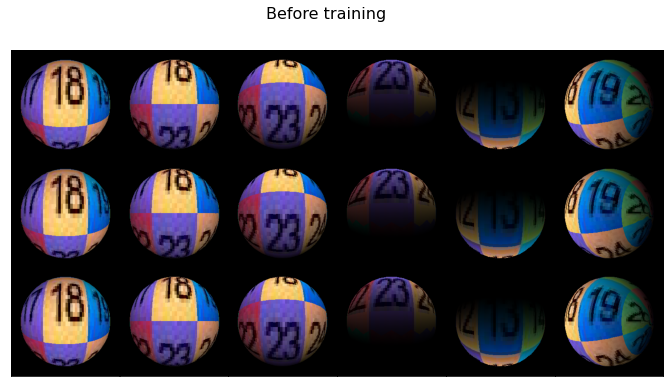

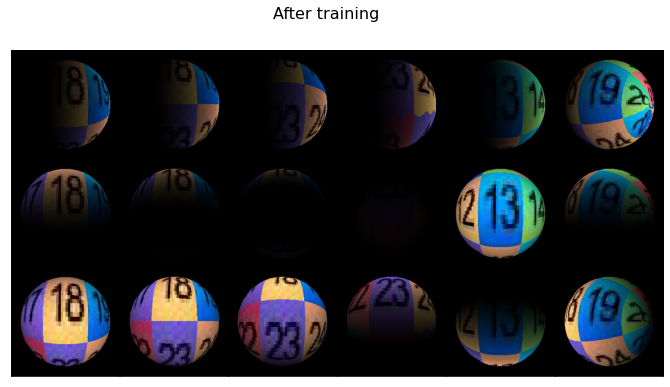

In [6]:
azimuth = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)
elevation = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)

def eval_diffuse(azimuth, elevation, im_world_normal, albedo):
    """Render diffuse component with sh9_irradiance"""
    directions = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    img = torch.zeros((directions.shape[0], *im_world_normal.shape), device='cuda')
    for j in range(directions.shape[0]):
        lighting_effect = kal.render.lighting.sh9_diffuse(
            directions[j],
            im_world_normal[hard_mask],
            albedo[hard_mask]
        )
        img[j, hard_mask] = lighting_effect
    return img

with torch.no_grad():
    sh_img = torch.clamp(eval_diffuse(
        azimuth, elevation, im_world_normal, albedo
    ), 0., 1.)
    disp_imgs(sh_img, "Before training")
    
optim = torch.optim.SGD([azimuth, elevation], lr=3., momentum=0.9)
for i in range(100):
    optim.zero_grad()
    sh_img = eval_diffuse(azimuth, elevation, im_world_normal, albedo)
    loss = torch.nn.functional.mse_loss(sh_img, sun_img)
    loss.backward()
    optim.step()

with torch.no_grad():
    sh_img = torch.clamp(eval_diffuse(
        azimuth, elevation, im_world_normal, albedo
    ), 0., 1.)
    disp_imgs(sh_img, "After training")

print("Final values:")
print("azimuth:", azimuth)
print("elevation:", elevation)

# Optimize Spherical Gaussian with Inner Product

Final values
azimuth: tensor([-0.0069,  1.6143,  2.6202], device='cuda:0', requires_grad=True)
elevation: tensor([-0.0558, -0.1748,  1.5906], device='cuda:0', requires_grad=True)
amplitude: tensor([[3.3212, 3.6102, 3.4986],
        [3.3556, 3.4937, 3.4712],
        [4.8308, 4.8094, 4.8919]], device='cuda:0', requires_grad=True)
sharpness: tensor([6.5298, 5.8731, 8.7434], device='cuda:0', requires_grad=True)


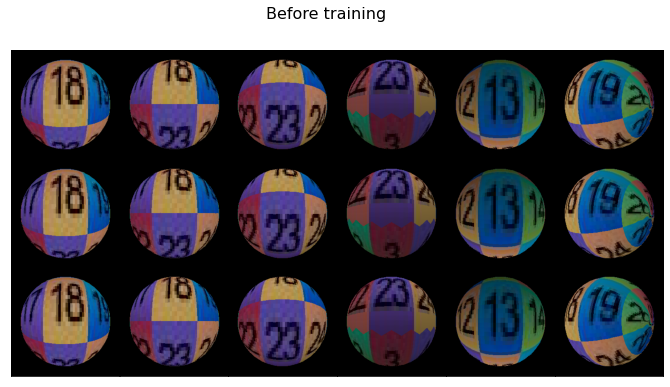

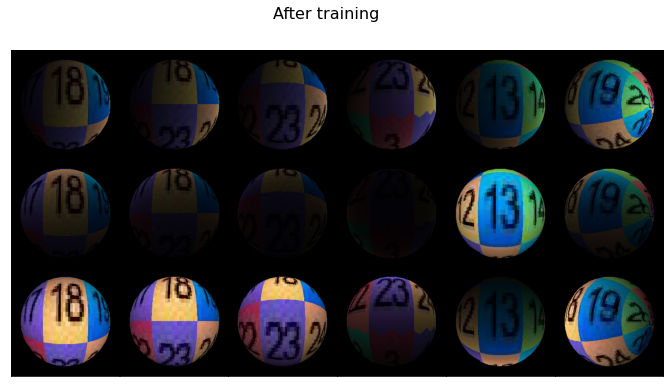

In [7]:
azimuth = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)
elevation = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)
amplitude = torch.ones((nb_scenes, 3), device='cuda', requires_grad=True)
sharpness = torch.ones((nb_scenes,), device='cuda', requires_grad=True)

def eval_diffuse(azimuth, elevation, amplitude, sharpness, im_world_normal, albedo):
    """Render diffuse component with sg_diffuse_inner_product"""
    directions = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    img = torch.zeros((directions.shape[0], *im_world_normal.shape), device='cuda')
    for j in range(directions.shape[0]):
        lighting_effect = kal.render.lighting.sg_diffuse_inner_product(
            amplitude[j:j + 1],
            directions[j:j + 1],
            sharpness[j:j + 1],
            im_world_normal[hard_mask],
            albedo[hard_mask]
        )
        img[j, hard_mask] = lighting_effect
    return img

with torch.no_grad():
    sg_inner_product_img = torch.clamp(eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    ), 0., 1)

    disp_imgs(sg_inner_product_img, "Before training")

optim = torch.optim.Adam([azimuth, elevation, amplitude, sharpness], lr=0.1)

# Optimization loop
for i in range(500):
    optim.zero_grad()
    sg_inner_product_img = eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    )
    loss = torch.nn.functional.mse_loss(sg_inner_product_img, sun_img)
    loss.backward()
    optim.step()

# Post-training evaluation
with torch.no_grad():
    sg_inner_product_img = torch.clamp(eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    ), 0., 1)

    disp_imgs(sg_inner_product_img, "After training")

print("Final values")
print("azimuth:", azimuth)
print("elevation:", elevation)
print("amplitude:", amplitude)
print("sharpness:", sharpness)

# Optimize Spherical Gaussian with Fitted approximation

We are gonna render with ``kaolin.render.sg_diffuse_fitted``, using a fitted approximation developed by [Stephen Hill](http://www.selfshadow.com/)

Final values
azimuth: tensor([-0.0025,  1.6121, -0.2346], device='cuda:0', requires_grad=True)
elevation: tensor([-0.0941, -0.1832,  1.5773], device='cuda:0', requires_grad=True)
amplitude: tensor([[3.6834, 3.8713, 3.8044],
        [3.3657, 3.3975, 3.4035],
        [5.0545, 5.0426, 5.0448]], device='cuda:0', requires_grad=True)
sharpness: tensor([6.7778, 5.5248, 9.0734], device='cuda:0', requires_grad=True)


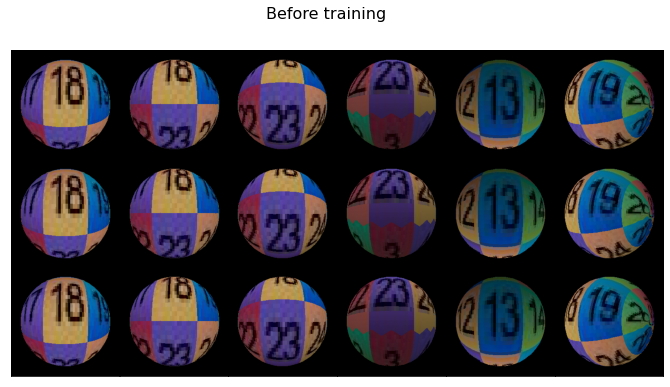

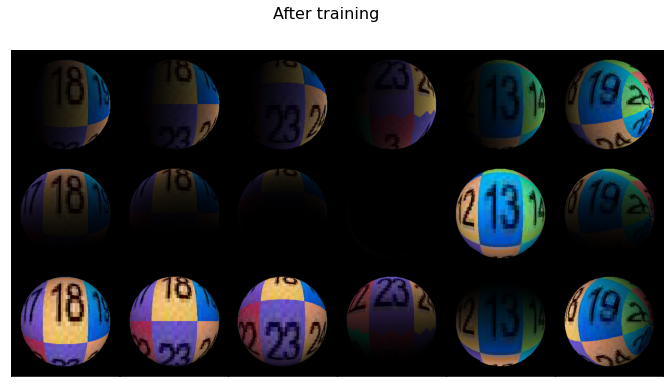

In [8]:
azimuth = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)
elevation = torch.full((nb_scenes,), math.pi / 2., device='cuda', requires_grad=True)
amplitude = torch.ones((nb_scenes, 3), device='cuda', requires_grad=True)
sharpness = torch.ones((nb_scenes,), device='cuda', requires_grad=True)

def eval_diffuse(azimuth, elevation, amplitude, sharpness, im_world_normal, albedo):
    """Render diffuse component with sg_diffuse_fitted"""
    directions = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    img = torch.zeros((nb_scenes, *im_world_normal.shape), device='cuda')
    for j in range(nb_scenes):
        lighting_effect = kal.render.lighting.sg_diffuse_fitted(
            amplitude[j:j + 1],
            directions[j:j + 1],
            sharpness[j:j + 1],
            im_world_normal[hard_mask],
            albedo[hard_mask]
        )
        img[j, hard_mask] = lighting_effect
    return img

with torch.no_grad():
    sg_fitted_img = torch.clamp(eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    ), 0., 1)

    disp_imgs(sg_fitted_img, "Before training")

optim = torch.optim.Adam([azimuth, elevation, amplitude, sharpness], lr=0.1)

# Optimization loop
for i in range(500):
    optim.zero_grad()
    sg_fitted_img = eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    )
    loss = torch.nn.functional.mse_loss(sg_fitted_img, sun_img)
    loss.backward()
    optim.step()

# Post-training evaluation
with torch.no_grad():
    sg_fitted_img = torch.clamp(eval_diffuse(
        azimuth, elevation, amplitude, sharpness, im_world_normal, albedo
    ), 0., 1)

    disp_imgs(sg_fitted_img, "After training")

print("Final values")
print("azimuth:", azimuth)
print("elevation:", elevation)
print("amplitude:", amplitude)
print("sharpness:", sharpness)

# Final comparison

Comparing the results with each lighting method,

you can modify the variables ``scene_idx`` and ``view_idx``

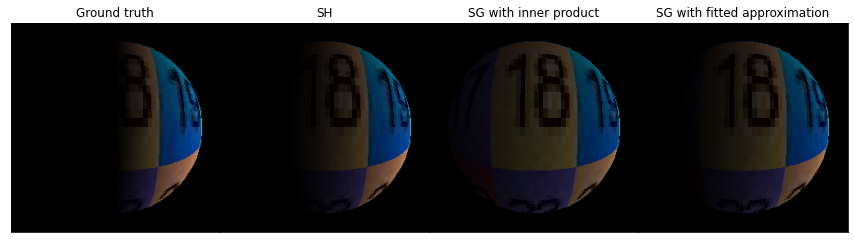

In [9]:
scene_idx = 0
view_idx = 0
f, axes = plt.subplots(1, 4, figsize=(15, 7))
plt.subplots_adjust(wspace=0, hspace=0)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].imshow(sun_img[scene_idx, view_idx].cpu().detach())
axes[0].title.set_text('Ground truth')
axes[1].imshow(sh_img[scene_idx, view_idx].cpu().detach())
axes[1].title.set_text('SH')
axes[2].imshow(sg_inner_product_img[scene_idx, view_idx].cpu().detach())
axes[2].title.set_text('SG with inner product')
axes[3].imshow(sg_fitted_img[scene_idx, view_idx].cpu().detach())
axes[3].title.set_text('SG with fitted approximation')